# Required libraries

In [ ]:
#import required libraries
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from keras.applications.resnet import ResNet50, ResNet101, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras import Model, layers, regularizers
from keras.metrics import Precision, Recall
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import AUC
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd
# import splitfolders
import numpy as np
import shutil
import glob
import os

sns.set()

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

#change to directory
# %cd /content/drive/MyDrive/Research/

Mounted at /content/drive


#Useful Functions

In [ ]:
# HELPER FUNCTION

#function to count images in subfolders:
def count_images(base_dir):
  allFiles = 0
  for subdir in os.listdir(base_dir):
      subdir_path = os.path.join(base_dir, subdir)
      if os.path.isdir(subdir_path):
          print(f"{len(os.listdir(subdir_path))} files in subdirectory {subdir}.")
      allFiles = allFiles + os.path.isdir(subdir_path)
  print(f"Total: {allFiles} files.")


def generators_train_val(shape, preprocessing, train_dir, val_dir, batch_size):
  #create training and validation datasets of given image shape

    train_datagen = ImageDataGenerator(
      preprocessing_function = preprocessing
    )

    height, width = shape

    train_dataset = train_datagen .flow_from_directory(
      train_dir,
      target_size = (height, width),
      class_mode= 'categorical',
      batch_size = batch_size,
    )

    val_dataset = train_datagen .flow_from_directory(
      val_dir,
      target_size = (height, width),
      class_mode= 'categorical',
      batch_size = batch_size,
    )

    return train_dataset, val_dataset

def generator_test(shape, preprocessing, test_dir, batch_size):
  #create training and validation datasets of given image shape

    train_datagen = ImageDataGenerator(
      preprocessing_function = preprocessing
    )

    height, width = shape

    test_dataset = train_datagen .flow_from_directory(
      test_dir,
      target_size = (height, width),
      class_mode= 'categorical',
      batch_size = batch_size,
      shuffle=False
    )

    return test_dataset

#function to plot accuracy and loss graphs:
def plot_acc_loss_graphs(model):
  auc_score = model.history.history['auc']
  val_auc_score = model.history.history['val_auc']
  loss =  model.history.history['loss']
  val_loss = model.history.history['val_loss']

  epochs = range(len(loss))

  # create a figure with 1 row and 3 columns
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

  for ax in axes:
      ax.set_facecolor('lightgray')
      ax.set_xlabel('epochs')
      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)
      ax.spines['bottom'].set_visible(False)
      ax.spines['left'].set_visible(False)

  # Plot training and validation auc
  axes[0].plot(epochs, auc_score, color='crimson', label='Training AUC score')
  axes[0].plot(epochs, val_auc_score, color='darkgreen', label='Validation AUC score')
  axes[0].set_ylabel('score')
  axes[0].set_title('Training and Validation Accuracy')
  axes[0].legend()
  axes[0].grid()


  # Plot training and validation loss
  axes[1].plot(epochs, loss, color='crimson', label='Training loss')
  axes[1].plot(epochs, val_loss, color='darkgreen', label='Validation loss')
  axes[1].set_ylabel('loss')
  axes[1].set_title('Training and Validation Loss')
  axes[1].legend()
  axes[0].grid()

  plt.show()


#function to plot classification report, AUROC and confusion matrix

def plot_evaluation_graphs(y_pred, test_dataset):
  true_images, true_labels = test_dataset.next()

  pred_rn = pd.get_dummies(np.argmax(y_pred, axis=-1)).to_numpy().astype(np.float32)

  # classification report
  print(classification_report(true_labels, pred_rn, target_names=classes))

  for label in range(class_count):
    fpr,tpr,thresholds = roc_curve(true_labels[:,label], y_pred[:,label])
    roc_auc = roc_auc_score(true_labels[:,label], y_pred[:,label])

  # create a figure with 1 row and 3 columns
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

  # evaluation results
  axes[0].plot([0,1],[0,1],'k:',label='Random')
  axes[0].plot(fpr, tpr, label='ROC curve for class {0} (AUC = {1:0.2f})'.format(classes[label], roc_auc))
  axes[0].set_xlabel('False Positive Rate')
  axes[0].set_ylabel('True Positive Rate')
  axes[0].set_title('AUROC metrics')
  axes[0].legend()
  axes[0].grid()

  # Confusion matrix results
  matrix = confusion_matrix(np.argmax(true_labels, axis=-1), np.argmax(pred_rn, axis=-1)) ## pred_x
  cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=classes)
  cm_display.plot(ax=axes[1])
  axes[1].set_title('Confusion Matrix')
  axes[1].grid(False)

  plt.show()


#functions to view sample images

def view_5_images(x, y, p, classes):
    indices = range(5)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, 1 +i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(classes[np.argmax(p[i])], color=col)
    plt.show()

def view_10_images(x, y, p, classes):
    indices = range(10)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, 1 +i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(classes[np.argmax(p[i])], color=col)
    plt.show()

def view_2_images(x, y, p, classes):
    plt.figure(figsize=(10, 5))

    for class_index, class_name in enumerate(classes):
        # Select first two images for this class
        class_indices = np.where(np.argmax(y, axis=1) == class_index)[0][:2]

        for i, index in enumerate(class_indices):
            plt.subplot(2, 5, class_index+1+i*5)
            plt.imshow(x[index])
            plt.xticks([])
            plt.yticks([])
            col = 'green' if np.argmax(y[index]) == np.argmax(p[index]) else 'red'
            plt.xlabel(classes[np.argmax(p[index])], color=col)

    plt.tight_layout()
    plt.show()



#####
#predicted results

def get_dataframe_results(y_pred, saved_model, ds_test):
  # Get the predicted class (0 or 1)
  y_pred = saved_model.predict(ds_test, verbose=1)

  # Get the list of image filenames from the generator
  image_filenames = ds_test.filepaths

  # Get the predicted class (0 or 1)
  predicted_classes = np.argmax(y_pred, axis=1)

  # Create a DataFrame with image filenames and predicted class
  df_results = pd.DataFrame({
      'Image_Filename': image_filenames,
      'Predicted_Class': predicted_classes,
      'Prediction_0': y_pred[:, 0],
      'Prediction_1': y_pred[:, 1]
      # Add other columns if needed, depending on your data
  })
  return df_results

  #separate into training folders

def move_predicted_images_into_folders(folder_b, folder_m, df_results):
  # Create folders if they don't exist
  for folder in [folder_b, folder_m]:
      os.makedirs(folder, exist_ok=True)

  # Iterate through the DataFrame and move images based on predicted class
  for index, row in df_results.iterrows():
      image_filename = row['Image_Filename']
      predicted_class = row['Predicted_Class']

      if predicted_class == 0:
          destination_folder = folder_b
      elif predicted_class == 1:
          destination_folder = folder_m
      else:
          # Handle other cases if needed
          continue

      # Construct the destination path
      destination_path = os.path.join(destination_folder, os.path.basename(image_filename))

      # Move the file
      shutil.move(image_filename, destination_path)

  print("Images moved successfully.")

def copy_jpg_images(source_folder, destination_folder):
    # Ensure the source folder exists
    if not os.path.exists(source_folder):
        print(f"Source folder '{source_folder}' does not exist.")
        return

    # Ensure the destination folder exists, create it if not
    os.makedirs(destination_folder, exist_ok=True)

    # Iterate through files in the source folder
    for file in os.listdir(source_folder):
        source_path = os.path.join(source_folder, file)

        # Check if the file is a JPG image
        if file.lower().endswith('.jpg'):
            destination_path = os.path.join(destination_folder, file)

            # Copy the file to the destination folder
            shutil.copy2(source_path, destination_path)

    print("Images copied successfully.")

def count_images_in_folder(folder_path):
    # Ensure the folder path exists
    if not os.path.exists(folder_path):
        print(f"Folder '{folder_path}' does not exist.")
        return 0

    # Get the list of files in the folder
    files = os.listdir(folder_path)

    # Filter only files (not directories)
    image_files = [file for file in files if os.path.isfile(os.path.join(folder_path, file))]

    # Count the number of image files
    num_images = len(image_files)

    return num_images


#Load Dataset

In [ ]:
train_dir = '/content/drive/MyDrive/all_mixed_data/fs/train'
val_dir = '/content/drive/MyDrive/all_mixed_data/fs/val'
test_dir = '/content/drive/MyDrive/all_mixed_data/fs/test'
classes = ['benign', 'malignant']
split_data=['test','train','val']
class_count=len(classes)

In [ ]:
count_images(train_dir)
count_images(val_dir)
count_images(test_dir)

261 files in subdirectory malignant.
261 files in subdirectory benign.
Total: 2 files.
67 files in subdirectory benign.
67 files in subdirectory malignant.
Total: 2 files.
35 files in subdirectory malignant.
35 files in subdirectory benign.
Total: 2 files.


#**FSL ALL PUBLIC DATA**

#VGG19

###Smaller generator - TAKEN

####Create and preprocess datasets

In [ ]:
#preprocess the datasets
ds_train_sm_rn, ds_val_sm_rn = generators_train_val((224,224), tf.keras.applications.vgg19.preprocess_input, train_dir, val_dir, 16)
ds_test_sm_rn = generator_test((224,224), tf.keras.applications.vgg19.preprocess_input, test_dir, 70)

Found 522 images belonging to 2 classes.
Found 134 images belonging to 2 classes.
Found 70 images belonging to 2 classes.


####Train, Compile & Fit Model

In [ ]:
pre_trained_model_rs = tf.keras.applications.VGG19(input_shape=(224,224, 3),
                             include_top = False,
                             weights = 'imagenet',
                             pooling='avg',
                             classes=2
                             )

#


80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
# Freeze layers
for layer in pre_trained_model_rs.layers:
  layer.trainable = False

x = pre_trained_model_rs.output
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)
output= layers.Dense(class_count, activation='sigmoid')(x)

#vgg19 model
vgg19_model = Model(inputs=pre_trained_model_rs.input, outputs=output)

In [ ]:
#model architecture
vgg19_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

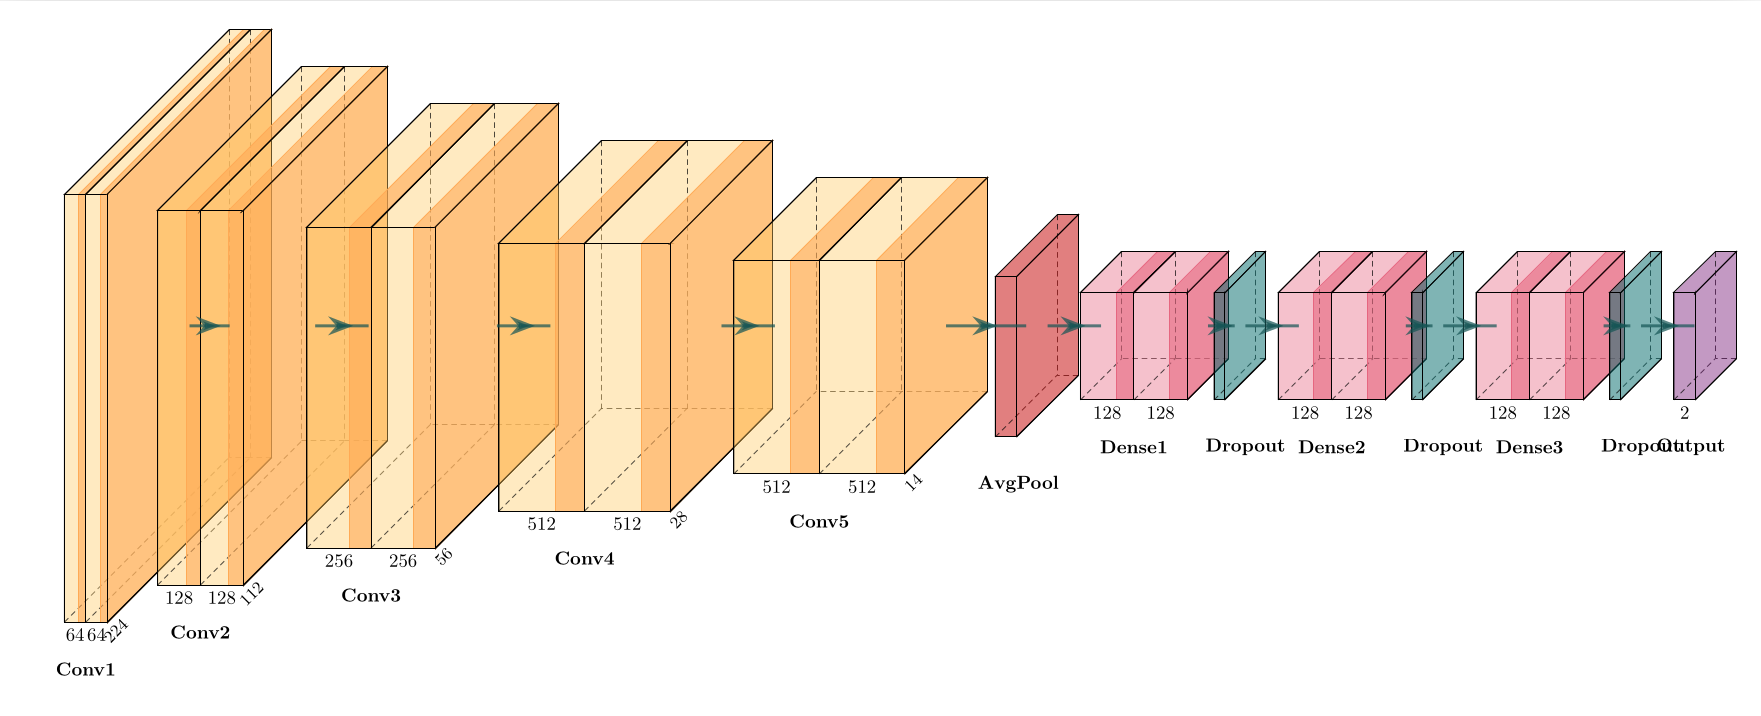

In [ ]:
# Compile model
vgg19_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.AUC(name='auc')])
              # tf.keras.metrics.AUC(name='auc')

# Train model
vgg19_model.fit(ds_train_sm_rn,
          validation_data=ds_val_sm_rn,
          epochs=200,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10)
          #           #  tf.keras.callbacks.ModelCheckpoint(monitor='val_auc')
                    ]
          )

Epoch 1/200
33/33 [==============================] - 6s 113ms/step - loss: 0.5070 - auc: 0.8148 - val_loss: 0.3551 - val_auc: 0.9135
Epoch 2/200
33/33 [==============================] - 3s 102ms/step - loss: 0.3387 - auc: 0.9037 - val_loss: 0.3480 - val_auc: 0.9249
Epoch 3/200
33/33 [==============================] - 3s 103ms/step - loss: 0.3088 - auc: 0.9321 - val_loss: 0.3636 - val_auc: 0.9199
Epoch 4/200
33/33 [==============================] - 3s 101ms/step - loss: 0.2246 - auc: 0.9630 - val_loss: 0.4146 - val_auc: 0.9326
Epoch 5/200
33/33 [==============================] - 3s 101ms/step - loss: 0.2052 - auc: 0.9692 - val_loss: 0.3498 - val_auc: 0.9394
Epoch 6/200
33/33 [==============================] - 3s 98ms/step - loss: 0.1643 - auc: 0.9803 - val_loss: 0.3231 - val_auc: 0.9417
Epoch 7/200
33/33 [==============================] - 3s 102ms/step - loss: 0.1319 - auc: 0.9871 - val_loss: 0.4013 - val_auc: 0.9472
Epoch 8/200
33/33 [==============================] - 3s 98ms/step - lo

####Performance

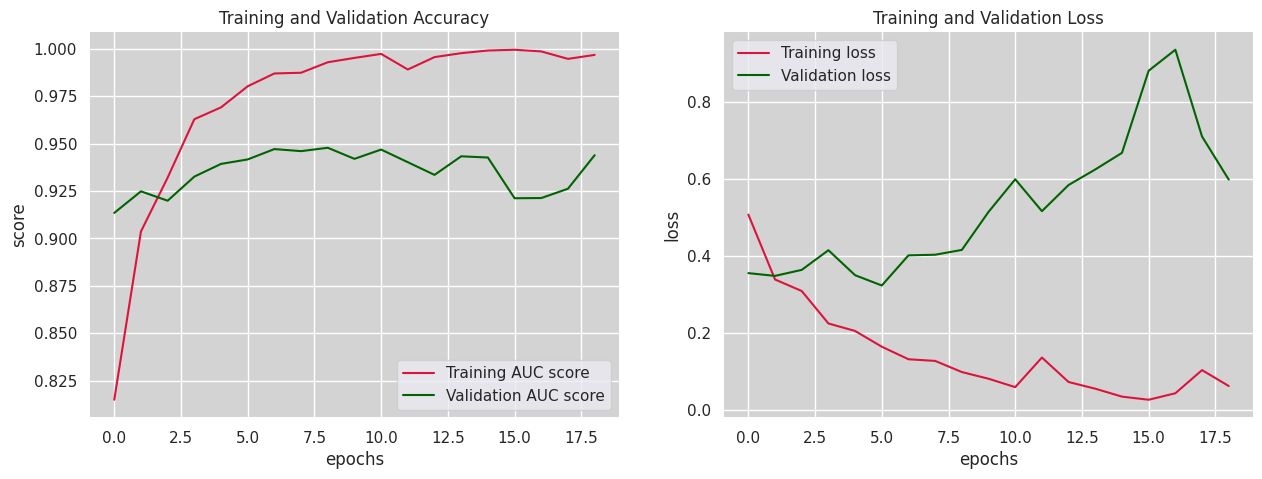

In [ ]:
plot_acc_loss_graphs(vgg19_model)

####Evaluation

In [ ]:
# # ##Evaluation
# # # resnet_model.save('/content/drive/MyDrive/Research/models/resnet_model_ai.h5')
# # # Assuming 'model' is your TensorFlow model
vgg19_model.save("/content/drive/MyDrive/models/vgg19_fsl_model_final.h5")
# # #load the model:
# # saved_resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/models/resnet50_sm_fsl_model_final.h5');

In [ ]:
y_pred_rn = vgg19_model.predict(ds_test_sm_rn, verbose=1)
print(f'y_pred_shape:{y_pred_rn.shape} and shape[0] is: {y_pred_rn.shape[0]}')

1/1 [==============================] - 0s 468ms/step
y_pred_shape:(70, 2) and shape[0] is: 70


              precision    recall  f1-score   support

      benign       0.54      0.57      0.56        35
   malignant       0.55      0.51      0.53        35

   micro avg       0.54      0.54      0.54        70
   macro avg       0.54      0.54      0.54        70
weighted avg       0.54      0.54      0.54        70
 samples avg       0.54      0.54      0.54        70



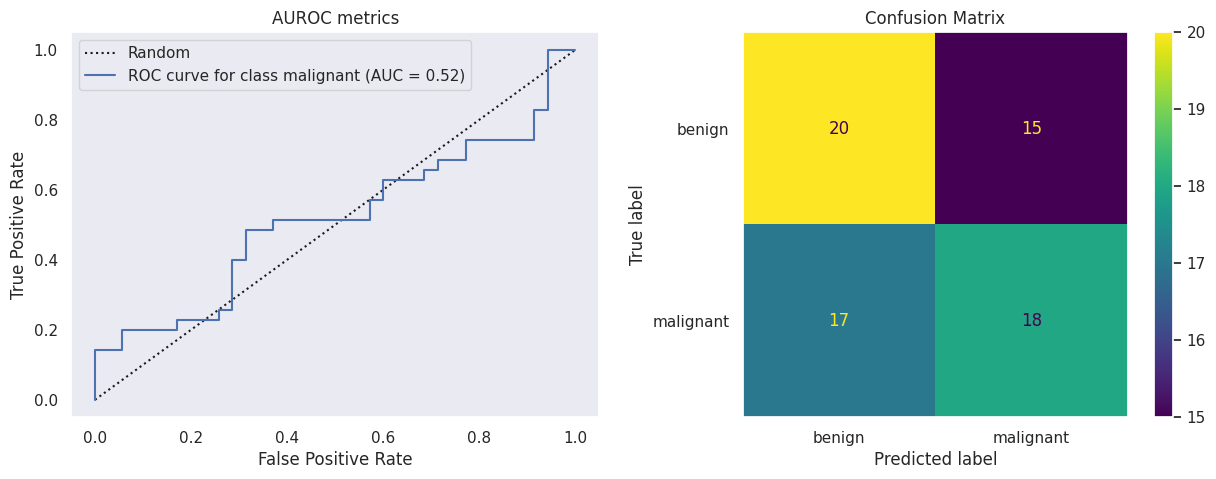

In [ ]:
plot_evaluation_graphs(y_pred_rn, ds_test_sm_rn)